## ARTEO - An Adaptive Real Time Exploration and Optimization Algorithm for Safety-Critical Systems: Bid Optimization

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern 
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(42)

### Data Pre-processing 

In [3]:
subcampaign_df = pd.read_csv("subcampaign_df.csv")

In [4]:
subcampaign_df.groupby(["click"]).count()

,weekday,hour,bidid,timestamp,logtype,ipinyouid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
click,,,,,,,,,,,,,,,,,,,,,
0,3669702,3669702,3669702,3669702,3669702,3669702,3669702,3669702,3669702,3669702,...,3669702,3669702,3669702,3669702,3669702,3669702,3669702,3669702,3669702,3163418
1,2637,2637,2637,2637,2637,2637,2637,2637,2637,2637,...,2637,2637,2637,2637,2637,2637,2637,2637,2637,2232


In [5]:
subcampaign_df.head(5)

,click,weekday,hour,bidid,timestamp,logtype,ipinyouid,useragent,IP,region,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,4,0,572fa35095e8b6c30b1aa871e52b2d,20130606000105075,1,Z0n7Ce1GPe5-toc,windows_chrome,120.40.95.*,124,...,280,0,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,87,bebefa5efe83beee17a3d245e7c5085b,1458,"10031,13042,10110"
1,0,4,0,e1e44b8a725b957a626991ecb15b56f,20130606000105119,1,VhkE1w9iOeu2eWz,windows_ie,60.163.144.*,94,...,280,2,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,33,bebefa5efe83beee17a3d245e7c5085b,1458,"10006,10110"
2,0,4,0,f250658c8cfc615c824f9552497d6325,20130606000105254,1,Vh1K15crOZ1djGn,windows_ie,123.120.244.*,1,...,280,2,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,65,bebefa5efe83beee17a3d245e7c5085b,1458,"10052,10006,10110"
3,0,4,0,85f33913696667652389ad45d1131977,20130606000105426,1,VhKC1w5aOluc3hb,windows_ie,110.179.226.*,15,...,280,2,1,0,77819d3e0b3467fe5c7b16d68ad923a1,300,129,bebefa5efe83beee17a3d245e7c5085b,1458,"10083,10063,10075,10052,10057,10006,10077,1427..."
4,0,4,0,8b089b1437f9937d4cd3bc8dcfc00285,20130606000105480,1,Vhk7ZAnyP8jWghz,windows_chrome,60.12.97.*,94,...,600,2,1,0,cb7c76e7784031272e37af8e7e9b062c,300,81,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10111"


In [6]:
subcampaign_df.columns

Index(['click', 'weekday', 'hour', 'bidid', 'timestamp', 'logtype',
       'ipinyouid', 'useragent', 'IP', 'region', 'city', 'adexchange',
       'domain', 'url', 'urlid', 'slotid', 'slotwidth', 'slotheight',
       'slotvisibility', 'slotformat', 'slotprice', 'creative', 'bidprice',
       'payprice', 'keypage', 'advertiser', 'usertag'],
      dtype='object')

In [7]:
subcampaign_df.groupby(["advertiser", "creative"])["click"].sum()

advertiser  creative                        
1458        2abc9eaf57d17a96195af3f63c45dc72     19
            48f2e9ba15708c0146bda5e1dd653caa    196
            612599432d200b093719dd1f372f7a30     26
            77819d3e0b3467fe5c7b16d68ad923a1    135
            832b91d59d0cb5731431653204a76c0e    235
                                               ... 
3476        bc27493ad2351e2577bc8664172544f8      1
            c938195f9e404b4f38c7e71bf50263e5     15
            e049ebe262e20bed5f9b975208db375b      9
            e1af08818a6cd6bbba118bb54a651961    117
            f65c8bdb41e9015970bac52baa813239     21
Name: click, Length: 74, dtype: int64

In [8]:
subcampaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672339 entries, 0 to 3672338
Data columns (total 27 columns):
 #   Column          Dtype  
---  ------          -----  
 0   click           int64  
 1   weekday         int64  
 2   hour            int64  
 3   bidid           object 
 4   timestamp       int64  
 5   logtype         int64  
 6   ipinyouid       object 
 7   useragent       object 
 8   IP              object 
 9   region          int64  
 10  city            int64  
 11  adexchange      int64  
 12  domain          object 
 13  url             object 
 14  urlid           float64
 15  slotid          object 
 16  slotwidth       int64  
 17  slotheight      int64  
 18  slotvisibility  int64  
 19  slotformat      int64  
 20  slotprice       int64  
 21  creative        object 
 22  bidprice        int64  
 23  payprice        int64  
 24  keypage         object 
 25  advertiser      int64  
 26  usertag         object 
dtypes: float64(1), int64(16), object(10)
memo

In [9]:
subcampaign_df["usertag"].head()

0                                    10031,13042,10110
1                                          10006,10110
2                                    10052,10006,10110
3    10083,10063,10075,10052,10057,10006,10077,1427...
4                                          13866,10111
Name: usertag, dtype: object

In [10]:
subcampaign_df["advertiser"].nunique()

5

In [11]:
subcampaign_df = subcampaign_df.drop(columns=["domain", "url", "urlid", "slotid", "keypage", "region", "city", "timestamp", "IP", "logtype","ipinyouid"])
subcampaign_df.columns

Index(['click', 'weekday', 'hour', 'bidid', 'useragent', 'adexchange',
       'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice',
       'creative', 'bidprice', 'payprice', 'advertiser', 'usertag'],
      dtype='object')

In [12]:
subcampaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672339 entries, 0 to 3672338
Data columns (total 16 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   click           int64 
 1   weekday         int64 
 2   hour            int64 
 3   bidid           object
 4   useragent       object
 5   adexchange      int64 
 6   slotwidth       int64 
 7   slotheight      int64 
 8   slotvisibility  int64 
 9   slotformat      int64 
 10  slotprice       int64 
 11  creative        object
 12  bidprice        int64 
 13  payprice        int64 
 14  advertiser      int64 
 15  usertag         object
dtypes: int64(12), object(4)
memory usage: 448.3+ MB


In [13]:
creative_df = pd.get_dummies(subcampaign_df['creative'].astype('str'))
old_col_names = creative_df.columns.to_list()
creative_df.rename({old_col_names[i]: f'creative_{i}' for i in range(len(old_col_names))}, axis=1, inplace=True)

In [14]:
# create user metadata - usertag
advertiser_df = pd.get_dummies(subcampaign_df['advertiser'].astype('str'))
advertiser_df.head()

,1458,3358,3386,3427,3476
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [15]:
# create user metadata - usertag
user_tag_df = subcampaign_df['usertag'].str.get_dummies(sep=',')
user_tag_df.head()

,10006,10024,10031,10048,10052,10057,10059,10063,10067,10074,...,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,1,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [16]:
subcampaign_df['usertag'].head()

0                                    10031,13042,10110
1                                          10006,10110
2                                    10052,10006,10110
3    10083,10063,10075,10052,10057,10006,10077,1427...
4                                          13866,10111
Name: usertag, dtype: object

In [17]:
user_tag_df = user_tag_df.add_prefix("usertag_")
user_tag_df.columns

Index(['usertag_10006', 'usertag_10024', 'usertag_10031', 'usertag_10048',
       'usertag_10052', 'usertag_10057', 'usertag_10059', 'usertag_10063',
       'usertag_10067', 'usertag_10074', 'usertag_10075', 'usertag_10076',
       'usertag_10077', 'usertag_10079', 'usertag_10083', 'usertag_10093',
       'usertag_10102', 'usertag_10110', 'usertag_10111', 'usertag_10684',
       'usertag_11092', 'usertag_11278', 'usertag_11379', 'usertag_11423',
       'usertag_11512', 'usertag_11576', 'usertag_11632', 'usertag_11680',
       'usertag_11724', 'usertag_11944', 'usertag_13042', 'usertag_13403',
       'usertag_13496', 'usertag_13678', 'usertag_13776', 'usertag_13800',
       'usertag_13866', 'usertag_13874', 'usertag_14273', 'usertag_16593',
       'usertag_16617', 'usertag_16661', 'usertag_16706'],
      dtype='object')

In [18]:
# create user metadata - useragent
useragent_df = subcampaign_df['useragent'].str.get_dummies()
useragent_df.head()

,android_chrome,android_firefox,android_ie,android_maxthon,android_opera,android_other,android_safari,android_sogou,ios_other,ios_safari,...,other_safari,windows_chrome,windows_firefox,windows_ie,windows_maxthon,windows_opera,windows_other,windows_safari,windows_sogou,windows_theworld
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [19]:
useragent_df.columns

Index(['android_chrome', 'android_firefox', 'android_ie', 'android_maxthon',
       'android_opera', 'android_other', 'android_safari', 'android_sogou',
       'ios_other', 'ios_safari', 'linux_chrome', 'linux_firefox', 'linux_ie',
       'linux_opera', 'linux_other', 'linux_safari', 'mac_chrome',
       'mac_firefox', 'mac_ie', 'mac_maxthon', 'mac_opera', 'mac_other',
       'mac_safari', 'mac_sogou', 'other_chrome', 'other_firefox', 'other_ie',
       'other_maxthon', 'other_opera', 'other_other', 'other_safari',
       'windows_chrome', 'windows_firefox', 'windows_ie', 'windows_maxthon',
       'windows_opera', 'windows_other', 'windows_safari', 'windows_sogou',
       'windows_theworld'],
      dtype='object')

In [20]:
useragent_df["android"] = useragent_df[['android_chrome', 'android_firefox', 'android_ie', 'android_maxthon',
       'android_opera', 'android_other', 'android_safari']].sum(axis=1)

useragent_df["windows"] = useragent_df[['windows_chrome', 'windows_firefox',
       'windows_ie', 'windows_maxthon', 'windows_opera', 'windows_other',
       'windows_safari', 'windows_sogou', 'windows_theworld']].sum(axis=1)

useragent_df["mac"] = useragent_df[['mac_chrome', 'mac_firefox',
       'mac_maxthon', 'mac_opera', 'mac_other', 'mac_safari', 'mac_sogou']].sum(axis=1)

useragent_df["ios"] = useragent_df[['ios_other', 'ios_safari']].sum(axis=1)

useragent_df["linux"] = useragent_df[['linux_chrome', 'linux_firefox', 'linux_opera',
       'linux_other', 'linux_safari']].sum(axis=1)

useragent_df["other"] = useragent_df[['other_chrome', 'other_firefox', 'other_ie', 'other_opera',
       'other_other', 'other_safari']].sum(axis=1)

useragent_df.drop(columns=['android_chrome', 'android_firefox', 'android_ie', 'android_maxthon',
       'android_opera', 'android_other', 'android_safari', 'ios_other',
       'ios_safari', 'linux_chrome', 'linux_firefox', 'linux_opera',
       'linux_other', 'linux_safari', 'mac_chrome', 'mac_firefox',
       'mac_maxthon', 'mac_opera', 'mac_other', 'mac_safari', 'mac_sogou',
       'other_chrome', 'other_firefox', 'other_ie', 'other_opera',
       'other_other', 'other_safari', 'windows_chrome', 'windows_firefox',
       'windows_ie', 'windows_maxthon', 'windows_opera', 'windows_other',
       'windows_safari', 'windows_sogou', 'windows_theworld'], inplace=True)

useragent_df.head()


,android_sogou,linux_ie,mac_ie,other_maxthon,android,windows,mac,ios,linux,other
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0


In [21]:
# create advertiser metadata - adexchange
adexchange_df = pd.get_dummies(subcampaign_df['adexchange'].astype(str))
adexchange_df = adexchange_df.add_prefix("adexchange_")
adexchange_df.head()

,adexchange_1,adexchange_2,adexchange_3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [22]:
subcampaign_df = subcampaign_df.drop(columns=["useragent", "usertag", "advertiser", "adexchange", "creative"])

In [23]:
list_of_dataframes = [subcampaign_df, user_tag_df, advertiser_df, useragent_df, adexchange_df, creative_df]
# list_of_dataframes = [subcampaign_df, useragent_df, adexchange_df]

subcampaign_df = pd.concat(list_of_dataframes, axis=1)
subcampaign_df.head()

,click,weekday,hour,bidid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,bidprice,...,creative_64,creative_65,creative_66,creative_67,creative_68,creative_69,creative_70,creative_71,creative_72,creative_73
0,0,4,0,572fa35095e8b6c30b1aa871e52b2d,336,280,0,1,0,300,...,0,0,0,0,0,0,0,0,0,0
1,0,4,0,e1e44b8a725b957a626991ecb15b56f,336,280,2,1,0,300,...,0,0,0,0,0,0,0,0,0,0
2,0,4,0,f250658c8cfc615c824f9552497d6325,336,280,2,1,0,300,...,0,0,0,0,0,0,0,0,0,0
3,0,4,0,85f33913696667652389ad45d1131977,336,280,2,1,0,300,...,0,0,0,0,0,0,0,0,0,0
4,0,4,0,8b089b1437f9937d4cd3bc8dcfc00285,160,600,2,1,0,300,...,0,0,0,0,0,0,0,0,0,0


### Exploratory Data Analysis

In [24]:
subcampaign_df.drop(columns=["bidprice"], inplace=True)
corr_df = subcampaign_df.corr()

In [25]:
import seaborn as sns

df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))
plt.figure(figsize = (16,16))
hmap=sns.heatmap(df_lt, linewidths=.5)
plt.show()
hmap.figure.savefig("Correlation_Heatmap_with_Seaborn.png",
                    format='png',
                    dpi=150)

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree
import shap


In [27]:
from sklearn.model_selection import train_test_split

final_df = subcampaign_df.dropna().drop(columns=["bidid"])
X = final_df.drop(columns=["click"])
y = final_df["click"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [28]:
# rebalance the imbalanced dataset
from imblearn.under_sampling import NearMiss
from collections import Counter
nm = NearMiss()

X_ress, y_ress = [] , []
for i in range(7):
    idx = subcampaign_df[subcampaign_df.weekday == i].index
    final_df = subcampaign_df.dropna().drop(columns=["bidid"]).iloc[idx]
    X = final_df.drop(columns=["click"])
    y = final_df["click"]
    X_res, y_res=nm.fit_resample(X,y)
    X_ress.append(X_res)
    y_ress.append(y_res)


In [29]:
X_res = pd.DataFrame(columns= X.columns, data = np.concatenate(X_ress))
y_res = pd.DataFrame(columns= ["click"], data = np.concatenate(y_ress))
# New count after balancing -> {0: 100, 1: 100}
print('Resampled dataset shape {}'.format(Counter(y_res["click"])))

Resampled dataset shape Counter({'click': 1})


In [30]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42)

In [31]:
model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.05)

In [32]:
# Fit the Model
model.fit(X_train_res, y_train_res)

[18:04:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type="bar")

In [34]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

y_pred = model.predict(X_test_res)
mse=accuracy_score(y_test_res, y_pred)

conf = confusion_matrix(y_test_res, y_pred)
print(conf)

print(np.sqrt(mse))
Counter(y_pred)

[[507   0]
 [ 20 528]]
0.9904759734735801


Counter({0: 527, 1: 528})

In [35]:
final_df = pd.concat([X_res, y_res], axis=1)
final_df = final_df.sample(frac=1).reset_index(drop=True)
final_df.columns

Index(['weekday', 'hour', 'slotwidth', 'slotheight', 'slotvisibility',
       'slotformat', 'slotprice', 'payprice', 'usertag_10006', 'usertag_10024',
       ...
       'creative_65', 'creative_66', 'creative_67', 'creative_68',
       'creative_69', 'creative_70', 'creative_71', 'creative_72',
       'creative_73', 'click'],
      dtype='object', length=144)

In [36]:
from xgboost.sklearn import XGBRegressor
# payprice prediction
X_pay = final_df.drop(columns=["payprice", "click"])
y_pay = final_df["payprice"]

X_train_pay, X_test_pay, y_train_pay, y_test_pay = train_test_split(
    X_pay, y_pay, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05)

model.fit(X_train_pay, y_train_pay)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [37]:
# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_pay)
shap.summary_plot(shap_values, features=X_pay, feature_names=X_pay.columns, plot_type="bar")

In [38]:
final_df = pd.concat([X_res, y_res])
final_df[["slotprice", "payprice"]].head()
final_df[["slotprice", "payprice"]][final_df.slotprice != 0]

In [41]:
final_df_ctr = 100* y_res.sum() / len(X_res)
final_df_ctr

click    50.0
dtype: float64

In [42]:
final_df_roi = y_res.sum()/ X_res["payprice"].sum()
final_df_roi

click    0.003955
dtype: float64

In [49]:
payprice_data = final_df.drop(columns=creative_df.columns.to_list())
click_data = final_df.copy()

click_data.shape , payprice_data.shape

((5274, 144), (5274, 70))

### The Algorithm Implementation   

In [106]:
# create subcampaigns
# campaigns are 1458, 3358, 3386, 3427, 3476
# subcampaigns are different days

def extract_subcampaigns(final_df: pd.DataFrame):
    subcampaign_df_dict = {i:pd.DataFrame([], columns = final_df.columns) for i in range(35)}
    for day in range(7):
        sub_df = final_df[final_df.weekday == day]
        sub_campaign_idxs = np.array_split(sub_df.index, 5)
        for sub_id in range(5):
            subcampaign_df_dict[day*5 + sub_id] = sub_df.loc[sub_campaign_idxs[sub_id]]

    return subcampaign_df_dict   

subcampaign_df_dict = extract_subcampaigns(final_df)
past_rois = []
for i in range(35):
    # print(Counter(subcampaign_df_dict[i]["click"]))
    past_rois.append(subcampaign_df_dict[i]["click"].sum()/subcampaign_df_dict[i]["payprice"].sum())

In [108]:
def objective_function(
    x, 
    click_data : pd.DataFrame, 
    payprice_data: pd.DataFrame,
    payprice_gpr: GaussianProcessRegressor, 
    number_of_click_gpr: GaussianProcessRegressor,
    exploration_signals: list,
):  
    # x is new opt pay price
    # produce predictions - will see the results for only bid rows
    global will_bid_rows
    
    slot_price = payprice_data["slotprice"].values
    will_bid_rows = pd.Index(np.where(x >= slot_price)[0].tolist(), dtype="int64")

    # for will bid rows
    click_predictions_mean, click_predictions_std  = number_of_click_gpr.predict(np.array(click_data.drop(columns=["click"]), dtype=object), return_std=True)

    # all rows
    payprice_mean, payprice_std = payprice_gpr.predict(np.array(payprice_data.drop(columns=["payprice"]), dtype=object), return_std=True)
    invest_values = []
    premium = []
    for i in range(len(x)):
        premium.append(np.abs(np.abs(x[i]) -  payprice_mean.tolist()[i]))
        invest_values.append(click_predictions_mean[i] * -10 * np.abs(x[i]))
      
    lower_confidence_bound = np.array([click_predictions_mean[i] - 0.01 * click_predictions_std.tolist()[i] for i in range(len(click_predictions_mean))])
    click_predictions_mean = np.where(lower_confidence_bound >= 0, [1], [0])

    total_payprice = np.sum(np.abs(x))

    if exploration_signals[-1] == exploration_signals[-2] == True:
        z = 0
    else:
        z = 0
    
    value =  np.sum(invest_values) + 10 * np.sum(premium) - z * (np.sum(payprice_std) + np.sum(click_predictions_std)) 
    return value


def min_roi_constraint(x, 
    payprice_data:pd.DataFrame, 
    click_data: pd.DataFrame,     
    payprice_gpr: GaussianProcessRegressor, 
    number_of_click_gpr: GaussianProcessRegressor 
)->float:

    # safety constraint 
    will_bid_rows = np.where(x > 0)
    click_predictions_mean, click_predictions_std  = number_of_click_gpr.predict(np.array(click_data.drop(columns=["click"]).iloc[will_bid_rows[0]], dtype=object), return_std=True)
    lower_confidence_bound = np.array([click_predictions_mean.tolist()[i] - 0.01 * click_predictions_std.tolist()[i] for i in range(len(click_predictions_mean))])
    click_predictions_mean = np.where(lower_confidence_bound >= 0.0, [1], [0])

    total_payprice = np.sum(np.abs(x))
    roi = np.sum(click_predictions_mean) / np.sum(total_payprice)
    return roi

def max_budget_constraint(x)->float:
    # total budget constraint
    total_payprice = np.sum(x)
    return np.sum(np.sum(total_payprice))

    
def optimization_function(
    click_data: pd.DataFrame, 
    payprice_data: pd.DataFrame, 
    payprice_gpr: GaussianProcessRegressor, 
    number_of_click_gpr: GaussianProcessRegressor,
    i: int,
    exploration_signals : list,
    x0 : list,
    method: str="COBYLA",
):
    min_roi_threshold = past_rois[i] * 0.9 
    print("New threshold is: ", min_roi_threshold)
    max_total_budget = 180 * click_data.shape[0]

    bmax_constraint = NonlinearConstraint(lambda x: min_roi_constraint(x, payprice_data, click_data,payprice_gpr, number_of_click_gpr), min_roi_threshold, np.inf, keep_feasible=True)
    total_constraint = NonlinearConstraint(lambda x: max_budget_constraint(x), 0, max_total_budget, keep_feasible=True)
    bounds = []
    for variables in x0:
        bounds.append((0, np.inf))
    
    res = minimize(objective_function, x0, 
        args=(click_data, payprice_data, payprice_gpr, number_of_click_gpr, exploration_signals), 
        bounds=bounds, constraints=(bmax_constraint, total_constraint), method=method, 
        options={
            "disp": True,
            "eps": 10.0,
            # "maxiter":3000,
            # "rhobeg": 10,
            }
    )
        
    return res.x


### Experiment

In [110]:
from scipy.stats import truncnorm
def get_normal_truncated(size:int, upper:float):
    lower = -1 * upper
    mu = 0
    sigma = 1
    return truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=size)

In [111]:
# it can do exploration with bidding different price for same slot price
# daily budget - constraint/threshold

kernel1 = Matern()
kernel2 = RBF()
number_of_click_gpr_exp = GaussianProcessRegressor(kernel=kernel1)
payprice_gpr_exp = GaussianProcessRegressor(kernel=kernel2)

def fit_gps(number_of_click_gpr_exp:GaussianProcessRegressor, payprice_gpr_exp:GaussianProcessRegressor, prev_payprice_data, prev_payprices, prev_clicks, prev_click_data):

    number_of_click_gpr_exp.fit(prev_click_data, prev_clicks)
    payprice_gpr_exp.fit(prev_payprice_data, prev_payprices)

    return number_of_click_gpr_exp, payprice_gpr_exp

safe_idx = pd.Index([])
safe_idx_pos = subcampaign_df_dict[0][subcampaign_df_dict[0]["click"]==1].index
safe_set_size = 30
safe_idx_pos = safe_idx_pos[:10]
safe_idx_neg =subcampaign_df_dict[0][subcampaign_df_dict[0]["click"]==0].index
safe_idx_neg = safe_idx_neg[:20]

safe_idx = safe_idx_pos.union(safe_idx_neg)

prev_payprice_data = payprice_data.loc[safe_idx].drop(columns=["payprice", "weekday"])
prev_payprices = payprice_data.loc[safe_idx]["payprice"]
prev_slot_prices = prev_payprice_data.loc[safe_idx]["slotprice"]
prev_click_data = click_data.loc[safe_idx].drop(columns=["click", "weekday"])
prev_clicks = click_data.loc[safe_idx]["click"]

# first training
number_of_click_gpr_exp, payprice_gpr_exp = fit_gps(number_of_click_gpr_exp, payprice_gpr_exp, prev_payprice_data, prev_payprices, prev_clicks, prev_click_data)
x = prev_payprices
x = np.ravel(x)

# produce predictions
click_predictions_mean, click_predictions_std  = number_of_click_gpr_exp.predict(np.array(click_data.iloc[safe_idx].drop(columns=["click", "weekday"]), dtype=object), return_std=True)
payprice_mean, payprice_std = payprice_gpr_exp.predict(np.array(payprice_data.iloc[safe_idx].drop(columns=["payprice", "weekday"]), dtype=object), return_std=True)
print("Click predictions mean:", np.sum(click_predictions_mean))
print("Payprice mean",np.sum(payprice_mean))

# store results
opt_prices_df_exp = pd.DataFrame({
    "opt_prices" : x, 
    "safe_idx": safe_idx.values.tolist(),
    "payprice_predictions_mean": payprice_mean,
    "payprice_predictions_std": payprice_std,
    "click_predictions_mean": click_predictions_mean,
    "click_predictions_std" : click_predictions_std,
    "rounds": [0] * safe_set_size
    })

first_30_roi =  prev_clicks.sum()/prev_payprices.sum()

opt_prices = np.array([])
global will_bid_rows 
will_bid_rows = safe_idx
safe_idx = safe_idx.values.tolist()

exploration_signals = [False, False]
explored = []

for i in range(0, 26):
   
    l = subcampaign_df_dict[i].index.tolist()

    idx = pd.Index(l[:200], dtype="int64")
    print(f"The dataset contains {len(idx)} rows")
    slotprices = payprice_data.loc[idx]["slotprice"].drop(columns=["weekday"]).values
    payprices =  payprice_data.loc[idx]["payprice"].drop(columns=["weekday"]).values

    click_data_batch = click_data.loc[idx].drop(columns=["weekday"])
    payprice_data_batch = payprice_data.loc[idx].drop(columns=["weekday"])

    click_predictions_mean, click_predictions_std  = number_of_click_gpr_exp.predict(np.array(click_data_batch.drop(columns=["click"]), dtype=object), return_std=True)
    min_prob = np.abs(np.min(click_predictions_mean))
    x0 = [180*(p+min_prob) for p in click_predictions_mean.tolist()]
    
    # feasible init
    x = optimization_function(click_data_batch, payprice_data_batch, payprice_gpr_exp, number_of_click_gpr_exp, i, exploration_signals, method="SLSQP", x0=x0)
            
    click_predictions_mean, click_predictions_std  = number_of_click_gpr_exp.predict(np.array(click_data_batch.drop(columns=["click"]), dtype=object), return_std=True)
    # click_predictions_mean = np.where(click_predictions_mean - 0.0002 * click_predictions_std > 0.00, [1], [0])
    lower_confidence_bound = np.array([click_predictions_mean.tolist()[i] - 0.01 * click_predictions_std.tolist()[i] for i in range(len(click_predictions_mean))])
    print("min:", min(lower_confidence_bound), " max:", max(lower_confidence_bound))
    click_predictions_mean = np.where(lower_confidence_bound >= 0.0, [1], [0])
    payprice_mean, payprice_std = payprice_gpr_exp.predict(np.array(payprice_data_batch.drop(columns=["payprice"]), dtype=object), return_std=True)
    
    print("Click predictions mean:", np.sum(click_predictions_mean))
    print("Payprice mean",np.sum(payprice_mean))
    print("Estimated ROI is:", np.sum([click_predictions_mean.tolist()[i] for i in range(len(x)) if x[i] > 0]) / np.sum(x))
    
    opt_prices_df_exp = pd.concat([opt_prices_df_exp, pd.DataFrame({
        "opt_prices" : x, 
        "safe_idx": idx.values.tolist(),
        "payprice_predictions_mean": payprice_mean,
        "payprice_predictions_std": payprice_std,
        "click_predictions_mean": click_predictions_mean,
        "click_predictions_std" : click_predictions_std,
        "rounds": i,
        })], join="outer")

    # don't share the reward of not-bid rows
    [safe_idx.append(v) for v in idx.values.tolist() if (v not in safe_idx and opt_prices_df_exp[(opt_prices_df_exp.safe_idx == v) & (opt_prices_df_exp.rounds == i)]["opt_prices"].values[0] > 0)]
    total_clicks= np.sum([payprice_data.loc[v]["click"] for v in safe_idx if len(opt_prices_df_exp[(opt_prices_df_exp.safe_idx == v) & (opt_prices_df_exp.rounds == i)]["opt_prices"]) > 0 and opt_prices_df_exp[(opt_prices_df_exp.safe_idx == v) & (opt_prices_df_exp.rounds == i)]["opt_prices"].values[0] > 0])
    total_payprices= np.sum([opt_prices_df_exp[(opt_prices_df_exp.safe_idx == v) & (opt_prices_df_exp.rounds == i)]["opt_prices"].values[0] for v in safe_idx if len(opt_prices_df_exp[(opt_prices_df_exp.safe_idx == v) & (opt_prices_df_exp.rounds == i)]["opt_prices"]) > 0 and opt_prices_df_exp[(opt_prices_df_exp.safe_idx == v) & (opt_prices_df_exp.rounds == i)]["opt_prices"].values[0] > 0])
    
    print("ROI is", total_clicks/total_payprices)
    print("Signal", np.sum(np.abs(x)) < np.sum(payprices) and past_rois[i] * 0.9 <= total_clicks/total_payprices)
    print("Explored", len(opt_prices_df_exp[(opt_prices_df_exp.rounds == i) & (opt_prices_df_exp.opt_prices > 0)])/len(idx))
    exploration_signals.append(np.sum(np.abs(x)) < np.sum(payprices) and past_rois[i] * 0.9 <= total_clicks/total_payprices)

    prev_payprices = payprice_data.loc[safe_idx]["payprice"].values +  get_normal_truncated(upper=np.inf, size=len(payprice_data.loc[safe_idx]["payprice"]))
    prev_slot_prices =payprice_data.loc[safe_idx]["slotprice"].values +  get_normal_truncated(upper=np.inf, size=len(payprice_data.loc[safe_idx]["slotprice"]))
    prev_payprice_data= payprice_data.loc[safe_idx].drop(columns=["payprice", "weekday"])
    prev_click_data = click_data.loc[safe_idx].drop(columns=["payprice", "weekday"])
    prev_clicks = click_data.loc[safe_idx]["click"].values 
    number_of_click_gpr_exp, payprice_gpr_exp = fit_gps(number_of_click_gpr_exp, payprice_gpr_exp, prev_payprice_data, prev_payprices, prev_clicks, prev_click_data)
    print("-------------------------------------------")


Click predictions mean: 9.999999999388349
Payprice mean 2696.9999998977255
The dataset contains 144 rows
New threshold is:  0.004796320630749014
Iteration limit reached    (Exit mode 9)
            Current function value: -16174.953995231597
            Iterations: 100
            Function evaluations: 15170
            Gradient evaluations: 100
min: -0.009999999999999907  max: 1.1604326480965863
Click predictions mean: 56
Payprice mean 8559.195571266957
Estimated ROI is: 0.004796320630757273
ROI is 0.006554399829195206
Signal True
Explored 1.2083333333333333
-------------------------------------------
The dataset contains 144 rows
New threshold is:  0.004503574265289913
Iteration limit reached    (Exit mode 9)
            Current function value: 84123.90244947508
            Iterations: 100
            Function evaluations: 15078
            Gradient evaluations: 99
min: -0.009999999999809394  max: 0.04317280475364378
Click predictions mean: 9
Payprice mean 10425.06772146697
Estimated

In [ ]:
opt_prices_df_exp = pd.merge(opt_prices_df_exp, payprice_data[["slotprice", "payprice"]], left_on="safe_idx", right_index=True, how="left")
opt_prices_df_exp = pd.merge(opt_prices_df_exp, click_data["click"], left_on="safe_idx", right_index=True, how="left")
opt_prices_df_exp = opt_prices_df_exp[["safe_idx", "rounds", "click_predictions_mean",  "click_predictions_std", 
"click", "opt_prices", "payprice", "slotprice", "payprice_predictions_mean", "payprice_predictions_std"]]
opt_prices_df_exp.head(50)

,safe_idx,rounds,click_predictions_mean,click_predictions_std,click,opt_prices,payprice,slotprice,payprice_predictions_mean,payprice_predictions_std
0,7,0,1.000000e+00,0.000010,1,1.690000e+02,169,5,1.690000e+02,0.000010
1,22,0,9.085852e-12,0.000006,0,7.000000e+01,70,70,7.000000e+01,0.000006
2,29,0,1.000000e+00,0.000010,1,1.500000e+02,150,5,1.500000e+02,0.000010
3,33,0,2.189416e-12,0.000010,0,8.000000e+01,80,80,8.000000e+01,0.000010
4,34,0,1.000000e+00,0.000010,1,5.000000e+01,50,50,5.000000e+01,0.000010
5,36,0,2.845984e-16,0.000007,0,8.000000e+01,80,80,8.000000e+01,0.000007
6,46,0,1.217998e-11,0.000010,0,7.000000e+01,70,70,7.000000e+01,0.000010
7,53,0,5.000000e-01,0.000007,1,1.400000e+02,140,140,1.400000e+02,0.000010
8,57,0,2.845984e-16,0.000007,0,8.000000e+01,80,80,8.000000e+01,0.000007
9,72,0,5.000000e-01,0.000007,0,1.400000e+02,140,140,1.400000e+02,0.000010


In [ ]:
# opt_prices_df_exp.to_csv("campaign_results.csv", index=False)
opt_prices_df_exp = pd.read_csv("campaign_results.csv")

In [ ]:
idxs_daily = [opt_prices_df_exp[opt_prices_df_exp.rounds == i]["safe_idx"].values.tolist() for i in range(25)]
rois = []
revenues = []
costs = []
clicks = []
cpc = []
safe_set_sizes = []
payprices = []
bidprices = []

for i in range(25):

    batch = opt_prices_df_exp[opt_prices_df_exp.rounds == i]
    bid_rows = batch[batch.opt_prices > 0]
    rois.append(np.sum(bid_rows["click"]) / np.sum(bid_rows["opt_prices"]))
    revenues.append(np.sum(bid_rows["click"] * np.abs(bid_rows["opt_prices"])))
    costs.append(np.sum(np.abs(bid_rows["opt_prices"])))
    total_achievable_clicks = np.sum(bid_rows["click"])
    achieved_click = np.sum(bid_rows[(bid_rows.click > 0) & (bid_rows.click_predictions_mean > 0)]["click"])
    clicks.append(100*achieved_click/total_achievable_clicks)
    cpc.append(np.sum(bid_rows[bid_rows > 0]["opt_prices"])/bid_rows[bid_rows > 0]["click"].count())
    safe_set_sizes.append(len(batch[batch.opt_prices > 0])/ len(batch))
    payprices.append(bid_rows["payprice"].mean())
    bidprices.append(bid_rows["opt_prices"].mean())



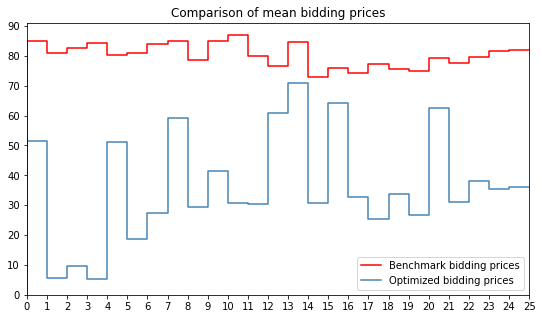

In [ ]:
days = [i for i in range(26)]

payprices = [0] + payprices
bidprices = [0] + bidprices
rois = [0] + rois

plt.figure(figsize=(9,5))
plt.step(days, payprices, label="Benchmark bidding prices", color="red", linewidth=1.5)
plt.step(days, bidprices, label="Optimized bidding prices", color="steelblue", linewidth=1.5)
plt.title("Comparison of mean bidding prices", fontsize=12)
plt.ylim([0, 91])
plt.yticks([i for i in range(0, 91, 10)])
plt.xticks([i for i in range(26)])
plt.margins(0,0)
plt.xlabel("Campaigns")
plt.ylabel("Mean bid prices")
plt.legend()
plt.show()
# plt.savefig("Comparison-bidding-prices.png", dpi=600)

In [ ]:
opt_prices_df_exp[(opt_prices_df_exp.safe_idx == 7) & (opt_prices_df_exp.rounds == 0)]["opt_prices"]

0    80.0
Name: opt_prices, dtype: float64

In [ ]:
# from pyomo.opt import SolverFactory
# from pyomo.environ import *
# import pyomo


# def objective_function(
#    opt_model: ConcreteModel
# ):
#     global number_of_click_gpr, payprice_gpr

#     # new pay price i slot price dan yuksek olanlar icin click prediction yap
#     # nereye bid ederse sadece onun mean ve std sini gorur
#     click_predictions_mean, click_predictions_std  = number_of_click_gpr.predict(np.array(click_data_batch.drop(columns=["click"]), dtype=object), return_std=True)
#     # click_predictions_mean = np.where(click_predictions_mean > 0.00, [1], [0])
#     # all rows
#     payprice_mean, payprice_std = payprice_gpr.predict(np.array(payprice_data_batch.drop(columns=["payprice"]), dtype=object), return_std=True)
#     # value = -np.sum(click_predictions_mean)  + 100 * (np.sum(payprice_std) + np.sum(click_predictions_std)) + np.sum(x)

#     def init_clicks(opt_model, i):
#         return click_predictions_mean[i-1]

#     def init_payprices(opt_model, i):
#         return payprice_mean[i-1]

#     opt_model.click_predictions_mean = Param(RangeSet(len(click_predictions_mean)),initialize=init_clicks)
#     opt_model.payprice_mean = Param(RangeSet(len(click_predictions_mean)),initialize=init_payprices)
#     opt_model.punishment = Param(initialize=10)
#     opt_model.reward = Param(initialize=-10)

#     invest_values = []
#     premium = []

#     for j in range(1,len(click_data_batch)+1):
#         i = opt_model.IDX[j]
#         premium.append(abs(opt_model.prices[i] -  opt_model.payprice_mean[j]) * opt_model.is_bid[i])
#         if opt_model.click_predictions_mean[j] > 0:
#             # reward
#             invest_values.append((opt_model.click_predictions_mean[j] * opt_model.reward * opt_model.prices[i]) * opt_model.is_bid[i])
#         else:
#             # punishment
#             invest_values.append(( opt_model.click_predictions_mean[j] * opt_model.punishment * opt_model.prices[i]) * opt_model.is_bid[i])
#     # print("invest_values",  sum(invest_values))
#     # print("10 * (np.sum(payprice_std) + np.sum(click_predictions_std))", 10 * (np.sum(payprice_std) + np.sum(click_predictions_std)))
#     # print("premium", sum(premium))
#     # value =  np.sum(invest_values) - 10 * (np.sum(payprice_std) + np.sum(click_predictions_std)) + np.sum(premium)
#     obj_value =  sum(invest_values) + sum(premium)
#     # print("obj value", obj_value)
#     # this is maximization problem so value will be opposite sign for minimization solution
#     return obj_value

# # safety constraint - tahmin edilenden 2 std asagida gelebilir click ona gore roi belirle
# def predict_clicks(
#     opt_model: ConcreteModel,
# ):
#     global number_of_click_gpr
#     index = pd.Index(opt_model.IDX, dtype="int64")

#     click_predictions_mean, click_predictions_std  = number_of_click_gpr.predict(click_data_batch.loc[index].drop(columns=["click"]).values, return_std=True)
#     click_predictions_mean = np.where(click_predictions_mean > 0, [1], [0])
#     # total_clicks = np.sum(click_predictions_mean)

#     def init_clicks(opt_model, i):
#         return click_predictions_mean[i-1]

#     opt_model.click_predictions_mean_r = Param(RangeSet(len(click_predictions_mean)), initialize=init_clicks, mutable=True)

#     return sum([opt_model.click_predictions_mean_r[i] * opt_model.is_bid[j] for i,j in zip(range(1,len(click_data_batch)+1),opt_model.IDX)])/sum([opt_model.prices[c] for c in opt_model.IDX]) >=  opt_model.min_roi_threshold
    
#     # lower_confidence_bound = [1 if bound > 0 else 0 for bound in lower_confidence_bound]
#     # total_payprice = np.sum(np.abs(x))
#     # roi = np.sum(click_predictions_mean) / np.sum(total_payprice)
#     # print(roi)
#     # # print(roi)
#     # min_roi_threshold = 0.001
#     # if roi <=  min_roi_threshold:
#     #     return Constraint.Infeasible
#     # else:
#     #     return Constraint.Feasible


# def optimization_model(idx):

#     opt_model = ConcreteModel()
#     max_total_budget = 180 * click_data_batch.shape[0]
#     print(max_total_budget)
#     # min_roi_threshold = 0.0000

#     opt_model.min_roi_threshold = Param(initialize=0.01)

#     x0 = {idx : 1 for idx in payprice_data_batch.index.tolist()}
#     # set of row indices
#     I = idx.tolist()

#     def init_prices(opt_model , i):
#         return random.randint(0,50)
#         # return 50
    
#     def init_bids(opt_model , i):
#         return np.random.randint(0, 1)
#         # return 0

#     #Variable declaration
#     np.random.seed(42)
#     opt_model.IDX = Set(initialize=x0.keys())
#     opt_model.prices = Var(opt_model.IDX, within=NonNegativeReals, initialize=init_prices, bounds=(0,500))
#     opt_model.is_bid = Var(opt_model.IDX, within=Binary, initialize=init_bids)
#     opt_model.per_budget = Param(initialize=500)
#     # print(opt_model.var.sI)
#     #Objective function definition
#     opt_model.obj = Objective(rule=objective_function, sense=pyomo.core.base.minimize)

#     #Constraint definition
#     # opt_model.cons1 = Constraint(expr = sum([min_roi_constraint(opt_model.prices[c]) for c in I])/sum([opt_model.prices[c] for c in I]) >= min_roi_threshold, doc = 'Minimum ROI Constraint')
    
#     # Constraint 1
#     opt_model.cons1 = Constraint(rule = predict_clicks, doc = 'Minimum ROI Constraint')

#     def max_total_budget_rule(opt_model):
#         return sum([opt_model.prices[c] for c in opt_model.IDX]) <= max_total_budget

#     # Constraint 2
#     opt_model.cons2 = Constraint(rule = max_total_budget_rule, doc="Maximum Total Budget")
    
#     def check_is_bid(opt_model, i):
#         return opt_model.prices[i] <= opt_model.is_bid[i] * opt_model.per_budget

#     # Constraint 3
#     opt_model.cons3 = Constraint(opt_model.IDX, rule = check_is_bid) 

#     #Solver options
#     results = SolverFactory('ipopt', executable="/opt/homebrew/bin/ipopt").solve(opt_model, tee=True)

#     results.write()

#     res_x = [opt_model.prices[c]() for c in I]
#     print("\n RESULTS \n")
#     print('Objective Function = ', opt_model.obj())
#     return res_x

# # optimization_model(idx)

In [ ]:
# safe_idx = pd.Index([])
# safe_idx_pos = final_df[final_df["click"] == 1].index
# safe_set_size = 20
# safe_idx_pos = safe_idx_pos[:safe_set_size//2]
# safe_idx_neg = final_df[final_df["click"] == 0].index
# safe_idx_neg = safe_idx_neg[:safe_set_size//2]

# safe_idx = safe_idx_pos.union(safe_idx_neg)
# # print(safe_idx)
# prev_payprice_data = payprice_data.loc[safe_idx].drop(columns=["payprice"])
# prev_payprices = payprice_data.loc[safe_idx]["payprice"]
# prev_slot_prices = prev_payprice_data.loc[safe_idx]["slotprice"]
# prev_click_data = click_data.loc[safe_idx].drop(columns=["click"])
# prev_clicks = click_data.loc[safe_idx]["click"]

# first_20_roi =  prev_clicks.sum()/prev_payprices.sum()
# first_20_roi

# opt_prices = np.array([])
# global will_bid_rows 
# will_bid_rows = safe_idx
# safe_idx = safe_idx.values.tolist()
# for i in range(0,7):
#     idx = payprice_data[payprice_data["weekday"] == i].index.values.tolist()
#     idx = pd.Index(set(idx+safe_idx), dtype="int64")
#     # print("idx", idx)
#     slotprices = payprice_data.loc[idx]["slotprice"].values
#     payprices =  payprice_data.loc[idx]["payprice"].values
#     fit_gps(prev_payprice_data, prev_payprices, prev_clicks, prev_click_data)
#     x = optimization_function(click_data.loc[idx], payprice_data.loc[idx])
#     x = np.stack(x, axis=0 )
#     x = np.ravel(x)
#     print("lenx", len(x))
#     prev_slot_prices = payprice_data.loc[idx]["slotprice"]
#     condition = np.where(x > prev_slot_prices)
#     opt_prices = np.append(opt_prices,x[condition])
#     [safe_idx.append(v) for v in will_bid_rows.values.tolist() if v not in safe_idx]
#     # print("safe indx", safe_idx)
#     print("ROI is", np.sum(payprice_data.loc[safe_idx]["click"])/ np.sum(opt_prices))
#     prev_payprices = payprice_data.loc[safe_idx]["payprice"]
#     prev_slot_prices = payprice_data.loc[safe_idx]["slotprice"]
#     prev_payprice_data= payprice_data.loc[safe_idx].drop(columns=["payprice"])
#     prev_click_data = click_data.loc[safe_idx].drop(columns=["payprice"])
#     prev_clicks = click_data.loc[safe_idx]["click"]
  

In [ ]:
# def objective_function(
#     x, 
#     click_data : pd.DataFrame, 
#     payprice_data: pd.DataFrame,
#     payprice_gpr: GaussianProcessRegressor, 
#     number_of_click_gpr: GaussianProcessRegressor
# ):
#     global will_bid_rows
#     # x is new opt pay price
#     # new pay price i slot price dan yuksek olanlar icin click prediction yap
#     #
#     # produce predictions
#     # nereye bid ederse sadece onun mean ve std sini gorur
#     slot_price = payprice_data["slotprice"].values
#     will_bid_rows = pd.Index(np.where(x >= slot_price)[0].tolist(), dtype="int64")
#     # print(will_bid_rows)
#     # for will bid rows
#     click_predictions_mean, click_predictions_std  = number_of_click_gpr.predict(np.array(click_data.drop(columns=["click"]), dtype=object), return_std=True)
#     # click_predictions_mean = np.where(click_predictions_mean > 0.00, [1], [0])
#     # all rows
#     payprice_mean, payprice_std = payprice_gpr.predict(np.array(payprice_data.drop(columns=["payprice"]), dtype=object), return_std=True)
#     # value = -np.sum(click_predictions_mean)  + 100 * (np.sum(payprice_std) + np.sum(click_predictions_std)) + np.sum(x)
#     # click_predictions = [click_predictions_mean[i] for i in range(len(click_predictions_mean))]
#     invest_values = []
#     premium = []
#     for i in range(len(x)):
#         premium.append(np.abs(np.abs(x[i]) -  payprice_mean.tolist()[i]))
#         if click_predictions_mean[i] > 0:
#             # reward
#             invest_values.append(click_predictions_mean[i] * -10 * np.abs(x[i]))
#         else:
#             # punishment
#             invest_values.append(click_predictions_mean[i] * 10 * np.abs(x[i]))
#     # print("invest_values",  np.sum(invest_values))
#     # print("10 * (np.sum(payprice_std) + np.sum(click_predictions_std))", 10 * (np.sum(payprice_std) + np.sum(click_predictions_std)))
#     # print("premium", np.sum(premium))
#     # value =  np.sum(invest_values) - 10 * (np.sum(payprice_std) + np.sum(click_predictions_std)) + np.sum(premium)
#     value =  np.sum(invest_values) + np.sum(premium)


#     # this is maximization problem so value will be opposite sign for minimization solution
#     return value
# def min_roi_constraint(x, 
#     payprice_data:pd.DataFrame, 
#     click_data: pd.DataFrame,     
#     payprice_gpr: GaussianProcessRegressor, 
#     number_of_click_gpr: GaussianProcessRegressor 
# )->float:
#     # safety constraint - tahmin edilenden 2 std asagida gelebilir click ona gore roi belirle
#     # produce predictions

#     will_bid_rows = np.where(x > 0)

#     click_predictions_mean, click_predictions_std  = number_of_click_gpr.predict(np.array(click_data.drop(columns=["click"]).iloc[will_bid_rows], dtype=object), return_std=True)
    
#     lower_confidence_bound = [click_predictions_mean.tolist()[i] - click_predictions_std.tolist()[i] for i in range(len(click_predictions_mean))]
    
#     click_predictions_mean = np.where(click_predictions_mean > 0, [1], [0])
#     lower_confidence_bound = [1 if bound > 0 else 0 for bound in lower_confidence_bound]
#     total_payprice = np.sum(np.abs(x))
#     roi = np.sum(click_predictions_mean) / np.sum(total_payprice)
#     # print(roi)
#     return roi
# def max_budget_constraint(x)->float:
#     # not safety constraint
#     total_payprice = np.sum(x)
#     return np.sum(np.sum(total_payprice))
# def optimization_function(
#     click_data: pd.DataFrame, 
#     payprice_data: pd.DataFrame, 
#     payprice_gpr: GaussianProcessRegressor, 
#     number_of_click_gpr: GaussianProcessRegressor,
# ):
#     min_roi_threshold = 0.001
#     max_total_budget = 180 * click_data.shape[0]

#     x0 = [50]  * len(payprice_data["payprice"].values.tolist())
#     bmax_constraint = NonlinearConstraint(lambda x: min_roi_constraint(x, payprice_data, click_data,payprice_gpr, number_of_click_gpr), min_roi_threshold, np.inf, keep_feasible=True)
#     total_constraint = NonlinearConstraint(lambda x: max_budget_constraint(x), 0, max_total_budget, keep_feasible=True)
#     bounds = []
#     for variables in x0:
#         bounds.append((0, np.inf))

#     res = minimize(objective_function, x0, args=(click_data, payprice_data, payprice_gpr, number_of_click_gpr), bounds=bounds, constraints=(bmax_constraint, total_constraint), method="SLSQP",options={
#         "disp": True,
#         "maxiter":2000})
#     return res.x
